In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

In [2]:
# plotting defaults
plt.rc('figure', figsize=(20, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

## Use SAAS data

In [3]:
df = pd.read_csv('saas.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790458 entries, 0 to 790457
Data columns (total 5 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Month_Invoiced     790458 non-null  object 
 1   Customer_Id        790458 non-null  int64  
 2   Invoice_Id         790458 non-null  int64  
 3   Subscription_Type  790458 non-null  float64
 4   Amount             790458 non-null  float64
dtypes: float64(2), int64(2), object(1)
memory usage: 30.2+ MB


In [5]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [6]:
df['Month_Invoiced'] = pd.to_datetime(df['Month_Invoiced'])
df = df.set_index('Month_Invoiced').sort_index()

In [7]:
df.index.month_name()

Index(['January', 'January', 'January', 'January', 'January', 'January',
       'January', 'January', 'January', 'January',
       ...
       'December', 'December', 'December', 'December', 'December', 'December',
       'December', 'December', 'December', 'December'],
      dtype='object', name='Month_Invoiced', length=790458)

### 1. Split data (train/test) and resample by any period except daily. Aggregate using the sum.

In [8]:
saas = df.resample('M')[['Amount']].sum()

In [9]:
saas.index.year

Int64Index([2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014, 2014,
            2014, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015, 2015,
            2015, 2015, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016, 2016,
            2016, 2016, 2016, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017,
            2017, 2017, 2017, 2017],
           dtype='int64', name='Month_Invoiced')

In [10]:
# split into train, validation, test
train = saas[:'2016']
test = saas['2017':]

plt.plot(train.index, train.Amount)
plt.plot(test.index, test.Amount)
plt.show()

In [11]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(test[target_var], label='Test', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [12]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df[target_var])), 0)
    return rmse

In [13]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
#### Simple Average

In [14]:
# compute simple average
avg_amount = round(train['Amount'].mean(), 2)
avg_amount

47916.67

In [15]:
yhat_df = pd.DataFrame({'Amount': [avg_amount]},
                          index=test.index)

In [16]:
yhat_df

,Amount
Month_Invoiced,
2017-01-31,47916.67
2017-02-28,47916.67
2017-03-31,47916.67
2017-04-30,47916.67
2017-05-31,47916.67
2017-06-30,47916.67
2017-07-31,47916.67
2017-08-31,47916.67
2017-09-30,47916.67


Amount -- RMSE: 5700


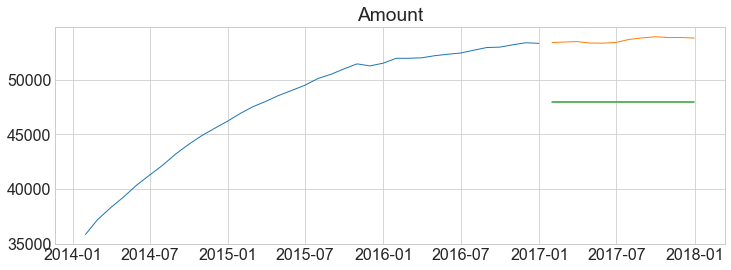

In [17]:
plot_and_eval('Amount')

In [18]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [19]:
eval_df = append_eval_df('Simple Average', 'Amount')

In [20]:
eval_df

,model_type,target_var,rmse
0,Simple Average,Amount,5700.0


#### Moving Average

In [21]:
rolling_amount = round(train['Amount'].rolling(1).mean()[-1], 2)

In [22]:
yhat_df = pd.DataFrame({'Amount': [rolling_amount]},
                          index=test.index)

Amount -- RMSE: 366


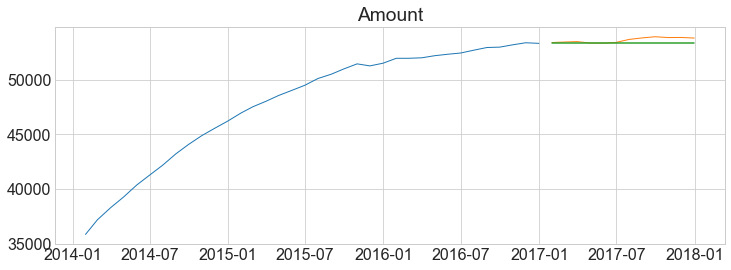

In [23]:
plot_and_eval('Amount')

In [24]:
eval_df = append_eval_df(model_type = '1_month_moving avg', 
                            target_var = 'Amount')

In [25]:
eval_df

,model_type,target_var,rmse
0,Simple Average,Amount,5700.0
1,1_month_moving avg,Amount,366.0


#### Holt's Linear Trend Model

In [26]:
model = Holt(train['Amount'], exponential=False, damped=True)
model = model.fit(optimized=True)

In [27]:
yhat_items = model.predict(start = test.index[0],
                           end = test.index[-1])
# add predictions to yhat_df
yhat_df['Amount'] = round(yhat_items, 2)

In [28]:
yhat_df

,Amount
Month_Invoiced,
2017-01-31,53519.52
2017-02-28,53641.20
2017-03-31,53761.74
2017-04-30,53881.17
2017-05-31,53999.49
2017-06-30,54116.71
2017-07-31,54232.84
2017-08-31,54347.89
2017-09-30,54461.87


Amount -- RMSE: 607


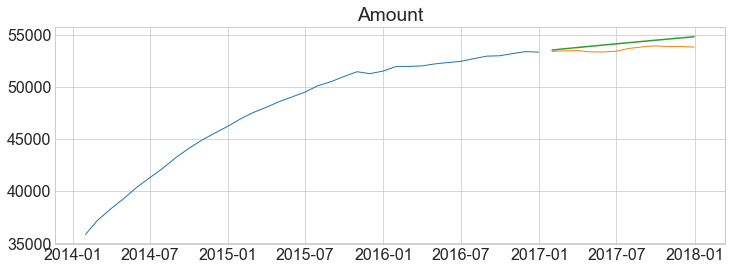

In [29]:
plot_and_eval(target_var = 'Amount')

In [30]:
eval_df = append_eval_df(model_type = "Holt's Linear Trend", 
                            target_var = 'Amount')

In [31]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
1,1_month_moving avg,Amount,366.0
2,Holt's Linear Trend,Amount,607.0
0,Simple Average,Amount,5700.0


#### Based on previous year/month/etc., this is up to you.

In [32]:
periods = [3, 6, 12, 18, 24]

for p in periods: 
    rolling_amount = round(train['Amount'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame({'Amount': [rolling_amount]},index=test.index)
    model_type = str(p) + '_month_moving_avg'
    eval_df = append_eval_df(model_type = model_type, target_var = 'Amount')

In [33]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
1,1_month_moving avg,Amount,366.0
3,3_month_moving_avg,Amount,386.0
4,6_month_moving_avg,Amount,574.0
2,Holt's Linear Trend,Amount,607.0
5,12_month_moving_avg,Amount,1024.0
6,18_month_moving_avg,Amount,1564.0
7,24_month_moving_avg,Amount,2509.0
0,Simple Average,Amount,5700.0
